### Basic Usage

Using prebuilt react agent

In [52]:
import os
from dotenv import load_dotenv

load_dotenv()

#ChatGoogleGenerativeAI does not yet have reliable structured tool 
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-04-17",
    google_api_key= os.getenv("GOOGLE_API_KEY"),
)

What we did in Langchain

In [53]:
from langchain_core.tools import tool

@tool
def magic_function(input: int) -> int:
    """Applies a magic function to an input."""
    return input + 2


tools = [magic_function]


query = "what is the value of magic_function(3)?"

llm_with_tools = llm.bind_tools(tools)

response = llm_with_tools.invoke(query)

response.tool_calls


#Agents exist in langchain but it is not used anymore
#agent = create_tool_calling_agent(model, tools, prompt)
#agent_executor = AgentExecutor(agent=agent, tools=tools)

[]

How to do it with react agent

In [54]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant"),
        ("placeholder", "{messages}"),
    ]
)


In [55]:
from langgraph.prebuilt import create_react_agent

langgraph_agent_executor = create_react_agent(llm, tools, prompt = prompt)


messages = langgraph_agent_executor.invoke({"messages": [("human", query)]})
{
    "input": query,
    "output": messages["messages"],
}

{'input': 'what is the value of magic_function(3)?',
 'output': [HumanMessage(content='what is the value of magic_function(3)?', additional_kwargs={}, response_metadata={}, id='58a69531-dba1-44e4-add6-584ccfb4087a'),
  AIMessage(content="I can call the magic_function with 3 as input, but I don't know the value it will return. Would you like me to call it?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-04-17', 'safety_ratings': []}, id='run-87d34de9-1400-432b-8b0e-2eadda1031ed-0', usage_metadata={'input_tokens': 58, 'output_tokens': 33, 'total_tokens': 278, 'input_token_details': {'cache_read': 0}})]}

In [56]:
messages = langgraph_agent_executor.invoke({"messages": [("human", query)]})
{
    "input": query,
    "output": messages["messages"][-1].content,
}


{'input': 'what is the value of magic_function(3)?',
 'output': 'The value of magic_function(3) is 5.'}

In [57]:
message_history = messages["messages"]

new_query = "Pardon?"

messages = langgraph_agent_executor.invoke(
    {"messages": message_history + [("human", new_query)]}
)
{
    "input": new_query,
    "output": messages["messages"][-1].content,
}

{'input': 'Pardon?',
 'output': 'I used the `magic_function` tool with the input `3`. The tool returned the output value of `5`. So, the value of `magic_function(3)` is 5.'}

In [58]:
from langchain.globals import set_verbose
from langchain.globals import set_debug 

set_verbose(False)
set_debug(True)

messages = langgraph_agent_executor.invoke(
    {"messages": message_history + [("human", "call the tool magic_function(3)")]}
)
{
    "input": "call the tool magic_function(3)",
    "output": messages["messages"][-1].content,
}

set_debug(False)


[chain/start] [chain:LangGraph] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:agent] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:agent > chain:call_model] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:agent > chain:RunnableSequence] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:agent > chain:RunnableSequence > prompt:ChatPromptTemplate] Entering Prompt run with input:
[inputs]
[chain/end] [chain:LangGraph > chain:agent > chain:RunnableSequence > prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [chain:LangGraph > chain:agent > chain:RunnableSequence > llm:ChatGoogleGenerativeAI] Entering LLM run with input:
{
  "prompts": [
    "System: You are a helpful assistant\nHuman: what is the value of magic_function(3)?\nAI: {'name': 'magic_function', 'arguments': '{\"input\": 3.0}'}\nTool: 5\nAI: The value of magic_function(3) i

### Memory

persistence and checkpointing

In [59]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

system_message = "You are a helpful assistant."


langgraph_agent_executor = create_react_agent(
    llm, tools, prompt=system_message, checkpointer=memory
)

config = {"configurable": {"thread_id": "test-thread"}}


In [60]:
print(
    langgraph_agent_executor.invoke(
        {
            "messages": [
                ("user", "Hi, My name is Utku! What's the output of magic_function of 3?")
            ]
        },
        config,
    )["messages"][-1].content
)
print("---")
print(
    langgraph_agent_executor.invoke(
        {"messages": [("user", "Remember my name?")]}, config
    )["messages"][-1].content
)
print("---")
print(
    langgraph_agent_executor.invoke(
        {"messages": [("user", "what was that output again?")]}, config
    )["messages"][-1].content
)



Hello Utku, the output of the magic_function of 3 is 5.
---
Yes, I remember that your name is Utku.
---
The output of the magic_function of 3 was 5.


### Basic Graphs

Building a basic chatbot

* StateGraph: object that defines the structure of our chatbot and saves the "states"

* Nodes: represents the llm and tools that our chatbot will call

* Edges: specifies how bot transition between nodes

In [61]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

Our graph can now handle two key tasks:

Each node can receive the current State as input and output an update to the state.
Updates to messages will be appended to the existing list rather than overwriting it, thanks to the prebuilt add_messages function used with the Annotated syntax.

In [62]:
def chatbot(state: State):
    return {"messages": llm.invoke(state["messages"])}

graph_builder.add_node("chatbot", chatbot)

In [63]:
graph_builder.add_edge(START, "chatbot")

graph_builder.add_edge("chatbot", END)

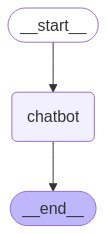

In [64]:
from IPython.display import Image, display

graph = graph_builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

running the graph

In [65]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        for step in graph.stream(
            {"messages": user_input}, stream_mode="updates"
        ):
            print("User: "+ user_input)
            for value in step.values():
                print("Assistant: " + value["messages"].content)

    except:
        break

Goodbye!


### Adding tools

In [66]:
@tool
def multiply(a: int, b: int) -> int:
    """Multiplies two integers ."""
    return a*b

tools = [multiply]

llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

Then we create a class that will check if the message contains a tool call

We will later replace this with LangGraph's prebuilt ToolNode to speed things up, but building it ourselves first is instructive.



In [67]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

Now we have to add an edge that will route to this node

In [68]:
def route_tools(state: State,):
   
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools" # the name of the node
    return END 



graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,

    {"tools": "tools", END: END},
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

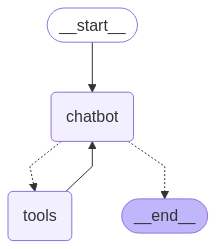

In [69]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

Running it

In [70]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        for step in graph.stream(
            {"messages": user_input}, stream_mode="updates"
        ):
            print("User: "+ user_input)
            for value in step.values():
                print(value["messages"])

    except:
        break

User: hi
[AIMessage(content='Hello! How can I help you today? I can multiply two integers for you.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-04-17', 'safety_ratings': []}, id='run-18959188-8896-4e2e-be23-ee05f705b2a7-0', usage_metadata={'input_tokens': 49, 'output_tokens': 17, 'total_tokens': 66, 'input_token_details': {'cache_read': 0}})]


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 46
}
].


### Memory

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition


memory = MemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [72]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(checkpointer=memory)

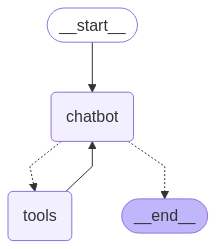

In [73]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [77]:
config = {"configurable": {"thread_id": "1"}}

user_input = "Hi there! My name is Will."

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will, it's nice to meet you! How can I help you today?


In [78]:
user_input = "Remember my name?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember! Your name is Will. How can I help you today, Will?


In [ ]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='58bd699b-f968-4f2b-a018-4be17087a293'), AIMessage(content="Hi Will, it's nice to meet you! How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-04-17', 'safety_ratings': []}, id='run-82e75c05-83fb-41e8-8581-db8668fdf93b-0', usage_metadata={'input_tokens': 56, 'output_tokens': 18, 'total_tokens': 108, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='b0aafe63-d0c0-4787-a771-0a856da2d1ec'), AIMessage(content='Yes, I remember! Your name is Will.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-04-17', 

### Customizable State

In [79]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str 

In [80]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt


@tool
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [81]:
tools = [human_assistance]

llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [82]:
user_input = (
    "John might be born in 12/04/2000 "
    "What is John's birthday? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

John might be born in 12/04/2000 What is John's birthday? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================

I understand you mentioned John might be born on 12/04/2000 and asked for his birthday. Since you provided a potential date and asked for the confirmed birthday, I will use the `human_assistance` tool to confirm or find the correct date. I will use the date you provided as the potential birthday in the tool.
Tool Calls:
  human_assistance (3ad7a024-424d-4219-9f0f-4449fb443096)
 Call ID: 3ad7a024-424d-4219-9f0f-4449fb443096
  Args:
    birthday: 12/04/2000
    name: John


In [83]:
human_command = Command(
    resume={
        "name": "John",
        "birthday": "Jan 17, 1999",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

I understand you mentioned John might be born on 12/04/2000 and asked for his birthday. Since you provided a potential date and asked for the confirmed birthday, I will use the `human_assistance` tool to confirm or find the correct date. I will use the date you provided as the potential birthday in the tool.
Tool Calls:
  human_assistance (3ad7a024-424d-4219-9f0f-4449fb443096)
 Call ID: 3ad7a024-424d-4219-9f0f-4449fb443096
  Args:
    birthday: 12/04/2000
    name: John
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'John', 'birthday': 'Jan 17, 1999'}
================================== Ai Message ==================================

After checking with a human, it seems John's birthday is actually Jan 17, 1999.


In [84]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'John', 'birthday': 'Jan 17, 1999'}

# LangGraph Server

Launch a LangGraph server locally and interact with it using the REST API and LangGraph Studio Web UI.

Also cloud option available


### LangGraph CLI

Creating a LangGraph app

"langgraph new path/to/your/app --template react-agent-python"

"langgraph dev"

### LangGraph Studio Web UI

LangGraph Studio Web is a specialized UI that you can connect to LangGraph API server to enable visualization, interaction, and debugging of your application locally. Test your graph in the LangGraph Studio Web UI by visiting the URL provided in the output of the langgraph dev command.

LangGraph Studio Web UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024



In [ ]:
from langgraph_sdk import get_client

client = get_client(url="http://localhost:2024")

async for chunk in client.runs.stream(
    None,  # Threadless run
    "agent", # Name of assistant. Defined in langgraph.json.
    input={
        "messages": [{
            "role": "human",
            "content": "What is LangGraph?",
        }],
    },
    stream_mode="updates",
):
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

ConnectError: All connection attempts failed